# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Для оценки качества моделей необходимо применить метрику RMSE.Значение должно быть меньше 2500.

## Подготовка данных

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

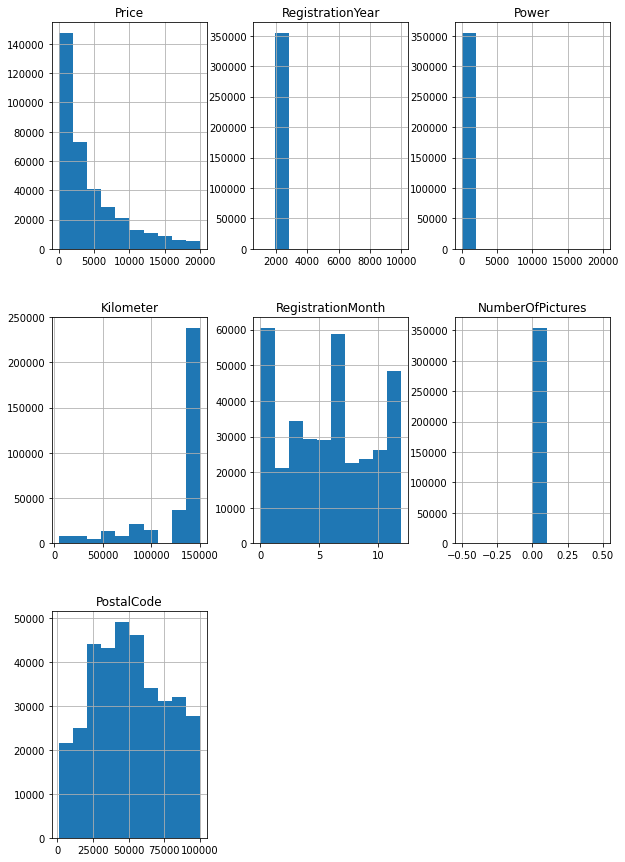

In [ ]:
df = pd.read_csv('/datasets/autos.csv')
display(df.head())
df.info()
df.hist(figsize=(10,15));

Файл содержит данные по 354369 технических характеристик и цен других автомобилей. Каждая строка данных описывается 16 признаками (7 количественных и 9 строчных).

В признаках VehicleTypeб Gearbox, Model, FuelType, Repaired есть пропущенные значения. Их необходимо обработать.

Также необходимо проверить данные на дублиткаты.

В файле есть свойства, которые не только не важны для обучения модели, но и могут послужить причиной ошибок, если их учиывать: дата скачивания анкеты из базы, дата создания анкеты, количесвто картинок, почтовый индекс и дата последней активности пользователя. Эти столбцы нужно удалить.

После удаления фамилии останутся 6 категориальных столбцов. Их необходимо закодировать с помощью OHE.

Кроме того, в подготовку данных должно войти разбиение выборки на обучающую, валидационную и тестовую. А также масштабирование численных признаков.

In [ ]:
#Удаление лишних столбцов 
data = df.drop(['DateCrawled','DateCreated','NumberOfPictures','PostalCode','LastSeen'], axis=1)

In [ ]:
#Подсчет пропусков в столбцах
data.isna().sum()

Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
dtype: int64

In [ ]:
#Просмотр уникальных значений в категориальных столбцах
print('VehicleType:', data['VehicleType'].unique())
print('Gearbox:', data['Gearbox'].unique())
print('Model:', data['Model'].sort_values().unique())
print('FuelType:', data['FuelType'].unique())
print('Repaired:', data['Repaired'].unique())

VehicleType: [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Gearbox: ['manual' 'auto' nan]
Model: ['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4'
 'c5' 'c_klasse' 'c_max' 'c_reihe' 'caddy' 'calibra' 'captiva' 'carisma'
 'carnival' 'cayenne' 'cc' 'ceed' 'charade' 'cherokee' 'citigo' 'civic'
 'cl' 'clio' 'clk' 'clubman' 'colt' 'combo' 'cooper' 'cordoba' 'corolla'
 'corsa' 'cr_reihe' 'croma' 'crossfire' 'cuore' 'cx_reihe' 'defender'
 'delta' 'discovery' 'doblo' 'ducato' 'duster' 'e_klasse' 'elefantino'
 'eos' 'escort' 'espace' 'exeo' 'fabia' 'fiesta' 'focus' 'forester'
 'forfour' 'fortwo' 'fo

In [ ]:
data['Gearbox'].value_counts()

manual    268251
auto       66285
Name: Gearbox, dtype: int64

В столбцах VehicleType, Model и FuelType целесообразно заполнить пропущенные значения вариантом 'other', т.к. мы сами его не можем указать в виду недостаточности обоснований. 

Больше всего значений в столбце Gearbox принадлежат значению "manual", пропуски предлагается заполнить им же. 

Пропуски в столбце Repaired будут заполнены значением 'no'.

In [ ]:
#Заполнение пропусков выбранными раннее значениями
data['VehicleType'] = data['VehicleType'].fillna('other')
data['Model'] = data['Model'].fillna('other')
data['FuelType'] = data['FuelType'].fillna('other')
data['Gearbox'] = data['Gearbox'].fillna('manual')
data['Repaired'] = data['Repaired'].fillna('no')
data.isna().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
dtype: int64

При просмотре диаграмм с численными методами, можно обнаружить аномалии, которые необходимо обработать.

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

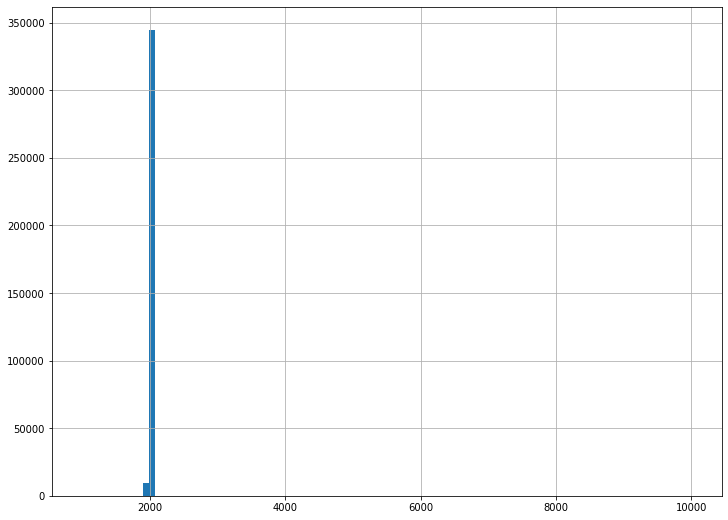

In [ ]:
data['RegistrationYear'].hist(bins=100, figsize=(12,9))
data['RegistrationYear'].describe()

В годе регистрации наблюдаются выбросы. Узнаем максимальную дату скачивания анкеты автомобиля, чтобы убрать правые даты.

In [ ]:
date = pd.to_datetime(df['DateCrawled'])
date.max()

Timestamp('2016-04-07 14:36:58')

Таким образом, даты регистрации после 2016 года некорректны. Машины появились не раньше 1900 года. Это дает возможность убрать ненужные года.

count    339773.000000
mean       2002.482222
std           7.091181
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

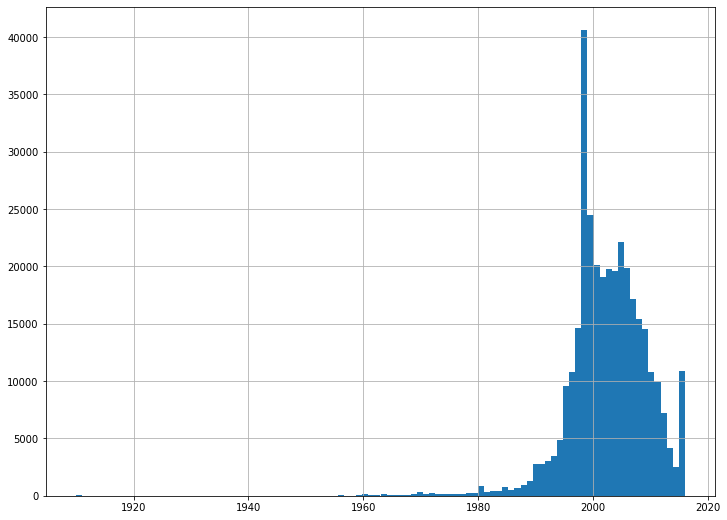

In [ ]:
data = data.query('1899 < RegistrationYear < 2017')
data['RegistrationYear'].hist(bins=100, figsize=(12,9))
data['RegistrationYear'].describe()

По левой части гистограммы видно, что разумно использовать 1960 год как левую границу, так как это старые, но возможно еще работающие машины.

In [ ]:
data = data.query('1959 < RegistrationYear < 2017')

Рассмотрим выбросы в столбце Мощности

count    339417.000000
mean        111.075341
std         186.925261
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

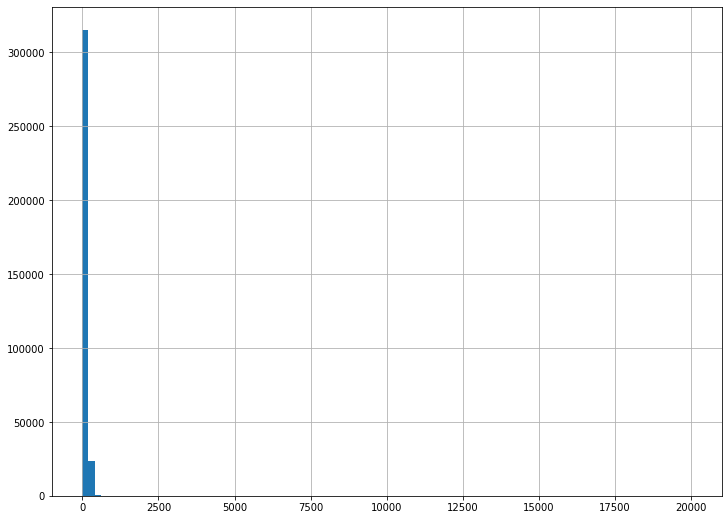

In [ ]:
data['Power'].hist(bins=100, figsize=(12,9))
data['Power'].describe()

count    339141.000000
mean        107.767377
std          63.898705
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max        1000.000000
Name: Power, dtype: float64

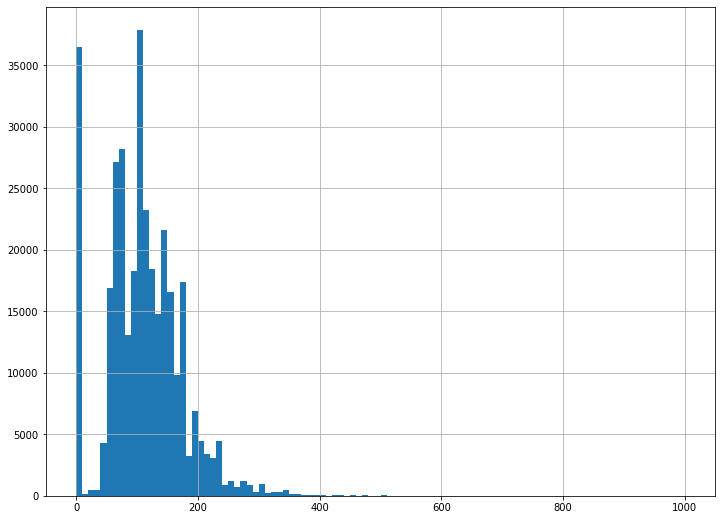

In [ ]:
data = data.query('Power < 1001')
data['Power'].hist(bins=100, figsize=(12,9))
data['Power'].describe()

Из графика видно, что многие машины имеют мощность 0. Эти строки не подлежат восстановлению и будут удалены. После изучения материалов по машиннам, становится ясно, что минимальное количество лошадинных сил необходимых машине примрно равно 20. По правому отсечению возьмеп границу в 400 л.с.

count    302068.000000
mean        120.267781
std          52.549122
min          21.000000
25%          75.000000
50%         110.000000
75%         150.000000
max         400.000000
Name: Power, dtype: float64

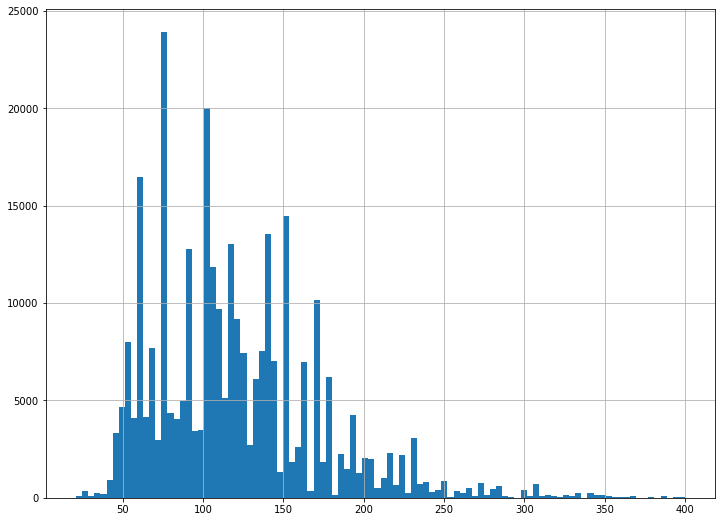

In [ ]:
data = data.query('20 < Power < 401')
data['Power'].hist(bins=100, figsize=(12,9))
data['Power'].describe()

In [ ]:
data['Price'].value_counts()

0       6365
500     4463
1500    4420
1200    3731
2500    3701
        ... 
679        1
6820       1
5185       1
5697       1
8188       1
Name: Price, Length: 3588, dtype: int64

Рассмотрим аномалии в целевом признаке.

В данных есть 10772 записи, где цена равна 0. Так быть не может, их необходимо убрать. 

count    295703.000000
mean       4843.661921
std        4601.375111
min           1.000000
25%        1333.000000
50%        3199.000000
75%        6990.000000
max       20000.000000
Name: Price, dtype: float64

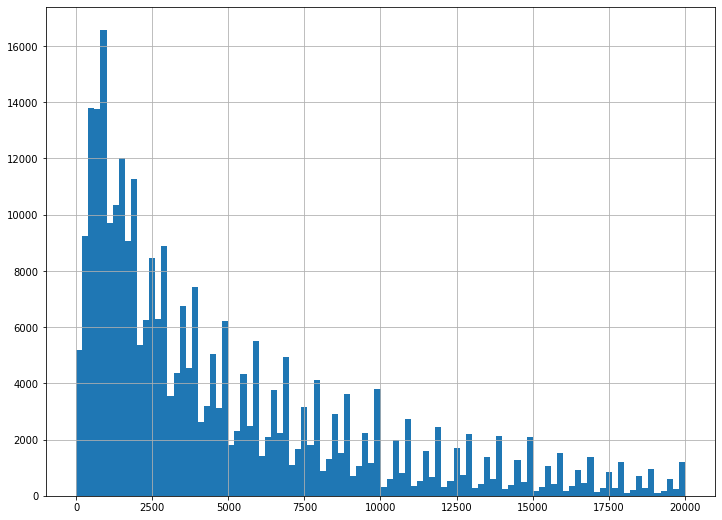

In [ ]:
data = data.query('Price > 0')
data['Price'].hist(bins=100, figsize=(12,9))
data['Price'].describe()

Выделим нижнюю границу с помощью квантиля 5%.

In [ ]:
data['Price'].quantile([.05])

0.05    450.0
Name: Price, dtype: float64

Стоимость 450 евро по текущему курсу примерно равно 36 000 рублей. Это минимальная цена для продажи поддержанного автомобиля. 

In [ ]:
data = data.query('450 <= Price')

**Вывод:** была произведена подготовка данных для дальнейшего обучения моделей.

## Обучение моделей

Для работы были выбраны модели LightGBM, DecisionTreeRegressor, CatBoost и LinearRegression.

### Разбиение данных на выборки

Для кодирования данных было применено порядковое кодирование. Но т.к. его нельзя применять для линейных моделей, для них было выбрано и применено OHE. Оно не использовалось для всех остальных моделей, т.к. для заказчика важно время обучения и скорость предсказания, а данные модели могут работать и с другими методами кодировками значительно быстреее, не теряя при этом в качестве.

In [ ]:
features = data.drop(['Price'], axis=1)
target = data['Price']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345)

#Прямое кодирование
encoder = OrdinalEncoder()
cat_columns = features_train.select_dtypes(include='object').columns.to_list()
cat_features = features_train[cat_columns]
cat_features = pd.DataFrame(encoder.fit_transform(cat_features),
                                columns=cat_features.columns, 
                                index=cat_features.index)
features_train = features_train.copy()
for column in cat_columns:
    features_train[column] = cat_features[column]

cat_features = features_test[cat_columns]
cat_features = pd.DataFrame(encoder.transform(cat_features),
                                columns=cat_features.columns, 
                                index=cat_features.index)
features_test = features_test.copy()
for column in cat_columns:
    features_test[column] = cat_features[column]

ohe_features_train = pd.get_dummies(features_train, drop_first=True)
ohe_features_test = pd.get_dummies(features_test, drop_first=True)

print(features_train.shape)
print(features_test.shape)
print(ohe_features_train.shape)
print(ohe_features_test.shape)

(210776, 10)
(70259, 10)
(210776, 10)
(70259, 10)


### Обучение моделей

#### Линейная регрессия

In [ ]:
%%time

slr = LinearRegression()
pipeline = make_pipeline(StandardScaler(), slr)
cv_results = cross_validate(pipeline, ohe_features_train, target_train, cv=5, 
                         scoring='neg_root_mean_squared_error')

CPU times: user 736 ms, sys: 704 ms, total: 1.44 s
Wall time: 1.51 s


In [ ]:
final_score_slr = cv_results['test_score'].mean()
print('Final score:  {:.3f}'.format(final_score_slr))
fit_time_slr = cv_results['fit_time'].mean()
score_time_slr = cv_results['score_time'].mean()
print('время обучения',cv_results['fit_time'].mean())
print('время предсказания',cv_results['score_time'].mean())


Final score:  -2937.386
время обучения 0.2443711280822754
время предсказания 0.05519084930419922


#### Дерево решений

In [ ]:
%%time

#Дерево решений
dtr = DecisionTreeRegressor(random_state=12345)
parametrs = { 'min_samples_leaf': [1, 2, 3],
              'max_depth': [1,3,5]}
grid_dtr = GridSearchCV(dtr, parametrs, cv=5, scoring='neg_root_mean_squared_error', n_jobs=2)
grid_dtr.fit(features_train, target_train)

CPU times: user 603 ms, sys: 270 ms, total: 873 ms
Wall time: 18.5 s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=12345),
             n_jobs=2,
             param_grid={'max_depth': [1, 3, 5], 'min_samples_leaf': [1, 2, 3]},
             scoring='neg_root_mean_squared_error')

In [ ]:
print(grid_dtr.best_params_)
final_score_dtr = grid_dtr.best_score_
print(grid_dtr.best_score_)
fit_time_dtr = grid_dtr.cv_results_['mean_fit_time'].mean()
print('Сренее время обучения:',grid_dtr.cv_results_['mean_fit_time'].mean())
score_time_dtr = grid_dtr.cv_results_['mean_score_time'].mean()
print('Сренее время предсказания:',grid_dtr.cv_results_['mean_score_time'].mean())

{'max_depth': 5, 'min_samples_leaf': 1}
-2428.4547037850593
Сренее время обучения: 0.5462644735972086
Сренее время предсказания: 0.014044645097520616


#### CatBoost

In [ ]:
%%time


cbr = CatBoostRegressor(random_state=12345)
parametrs = { 'learning_rate':[0.1, 0.5, 0.8],
              'depth': [1,3,5]}
grid_cbr = GridSearchCV(cbr,parametrs, cv=5, scoring='neg_root_mean_squared_error', n_jobs=2)
grid_cbr.fit(features_train, target_train)

0:	learn: 4444.0262368	total: 87.6ms	remaining: 1m 27s
1:	learn: 4304.7822467	total: 111ms	remaining: 55.2s
2:	learn: 4185.8772033	total: 154ms	remaining: 51.3s
3:	learn: 4083.3536775	total: 191ms	remaining: 47.7s
4:	learn: 3997.0104770	total: 217ms	remaining: 43.3s
5:	learn: 3914.1759447	total: 235ms	remaining: 38.9s
6:	learn: 3840.9227056	total: 259ms	remaining: 36.7s
7:	learn: 3771.1411518	total: 287ms	remaining: 35.5s
8:	learn: 3704.5747599	total: 321ms	remaining: 35.3s
9:	learn: 3645.5466837	total: 361ms	remaining: 35.7s
10:	learn: 3590.4411194	total: 380ms	remaining: 34.1s
11:	learn: 3540.3242314	total: 405ms	remaining: 33.4s
12:	learn: 3492.2365611	total: 435ms	remaining: 33.1s
13:	learn: 3448.1765431	total: 492ms	remaining: 34.7s
14:	learn: 3407.2769206	total: 546ms	remaining: 35.9s
15:	learn: 3368.5516755	total: 587ms	remaining: 36.1s
16:	learn: 3332.6922068	total: 630ms	remaining: 36.5s
17:	learn: 3298.9805545	total: 683ms	remaining: 37.3s
18:	learn: 3267.5993978	total: 721ms

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fdda38022e0>,
             n_jobs=2,
             param_grid={'depth': [1, 3, 5], 'learning_rate': [0.1, 0.5, 0.8]},
             scoring='neg_root_mean_squared_error')

In [ ]:
print(grid_cbr.best_params_)
final_score_cbr = grid_cbr.best_score_
print(grid_cbr.best_score_)
fit_time_cbr = grid_cbr.cv_results_['mean_fit_time'].mean()
print('Сренее время обучения:',grid_cbr.cv_results_['mean_fit_time'].mean())
score_time_cbr = grid_cbr.cv_results_['mean_score_time'].mean()
print('Сренее время предсказания:',grid_cbr.cv_results_['mean_score_time'].mean())

{'depth': 5, 'learning_rate': 0.5}
-1555.1882957520684
Сренее время обучения: 53.85100839402941
Сренее время предсказания: 0.08858415285746257


#### LightGBM

In [ ]:
%%time

lgbm = lgb.LGBMRegressor(objective ='regression',metric = 'mae',random_state = 12345)
parametrs = {
    'num_leaves':[26,36] ,  
    'n_estimators':[500,1000]} 

grid_lgbm = GridSearchCV(lgbm,parametrs, cv=5, scoring='neg_root_mean_squared_error', n_jobs=2)
grid_lgbm.fit(features_train, target_train)

866:	learn: 1355.1579235	total: 53.9s	remaining: 8.27s
867:	learn: 1355.0538228	total: 53.9s	remaining: 8.2s
868:	learn: 1354.8768284	total: 54s	remaining: 8.14s
869:	learn: 1354.6906559	total: 54.1s	remaining: 8.08s
870:	learn: 1354.4215212	total: 54.1s	remaining: 8.02s
871:	learn: 1354.1565485	total: 54.1s	remaining: 7.95s
872:	learn: 1353.8950475	total: 54.2s	remaining: 7.88s
873:	learn: 1353.7207700	total: 54.2s	remaining: 7.81s
874:	learn: 1353.5639025	total: 54.3s	remaining: 7.75s
875:	learn: 1353.3572567	total: 54.3s	remaining: 7.69s
876:	learn: 1353.2743775	total: 54.4s	remaining: 7.63s
877:	learn: 1353.1510010	total: 54.4s	remaining: 7.56s
878:	learn: 1352.9872146	total: 54.5s	remaining: 7.5s
879:	learn: 1352.8430518	total: 54.5s	remaining: 7.43s
880:	learn: 1352.6242895	total: 54.6s	remaining: 7.37s
881:	learn: 1352.4680503	total: 54.6s	remaining: 7.3s
882:	learn: 1352.3335380	total: 54.7s	remaining: 7.24s
883:	learn: 1352.1136867	total: 54.7s	remaining: 7.18s
884:	learn: 135

GridSearchCV(cv=5,
             estimator=LGBMRegressor(metric='mae', objective='regression',
                                     random_state=12345),
             n_jobs=2,
             param_grid={'n_estimators': [500, 1000], 'num_leaves': [26, 36]},
             scoring='neg_root_mean_squared_error')

In [ ]:
print(grid_lgbm.best_params_)
final_score_lgbm = grid_lgbm.best_score_
print(grid_lgbm.best_score_)
fit_time_lgbm = grid_lgbm.cv_results_['mean_fit_time'].mean()
print('Сренее время обучения:',grid_lgbm.cv_results_['mean_fit_time'].mean())
score_time_lgbm = grid_lgbm.cv_results_['mean_score_time'].mean()
print('Сренее время предсказания:',grid_lgbm.cv_results_['mean_score_time'].mean())

{'n_estimators': 1000, 'num_leaves': 36}
-1518.1754731488272
Сренее время обучения: 14.703131473064422
Сренее время предсказания: 4.639424991607666


### Анализ моделей

In [ ]:
index = ['LinearRegression',
         'DecisionTreeRegressor',
         'CatBoostRegressor',
         'LGBMRegressor']
data = {'RMSE на обучающей выборке, евро':['{:4.0f}'.format(final_score_slr * -1),
                            '{:4.0f}'.format(final_score_dtr * -1),
                            '{:4.0f}'.format(final_score_cbr * -1),
                            '{:4.0f}'.format(final_score_lgbm * -1)],
        'Время обучения модели, сек':[fit_time_slr,
                                          fit_time_dtr,
                                          fit_time_cbr,
                                          fit_time_lgbm],
        'Время предсказания модели, сек':[score_time_slr,
                                      score_time_dtr,
                                      score_time_cbr,
                                      score_time_lgbm],
        }

scores_data = pd.DataFrame(data=data, index=index)
scores_data

,"RMSE на обучающей выборке, евро","Время обучения модели, сек","Время предсказания модели, сек"
LinearRegression,2937,0.244371,0.055191
DecisionTreeRegressor,2428,0.546264,0.014045
CatBoostRegressor,1555,53.851008,0.088584
LGBMRegressor,1518,14.703131,4.639425


Из таблицы видно, что Линейная регрессия не достигла необходимого минимума в метрике. У CatBoost хорошая метрика, но самое большое время обучения. Из оставшихся двух выберем LGBM, т.к. у нее лучше метрика, и не очень большое время обучения и предсказания.

**Вывод:** были подобраны лучшие параметры для моделей LightGBM, DesicinTreeRegressor, CatBoost и LinearRegression, они были обучены на лучших параметрах, также с помощью них были получены предсказания; было измерено время их обучения и предсказания; получены метрики в каждом случае.

## Тестирование лучшей модели

In [ ]:
best_model = lgb.LGBMRegressor(objective ='regression',metric = 'mae',random_state = 12345, n_estimators=1000, num_leaves=36)
best_model.fit(features_train, target_train)
predictions = best_model.predict(features_test)
print('RMSE для тестовой выборке',mean_squared_error(target_test, predictions)**0.5)

RMSE для тестовой выборке 1511.6041050212425


In [ ]:
model_dummy_regressor = DummyRegressor()
model_dummy_regressor.fit(features_train, target_train)
predictions_test_dummy = model_dummy_regressor.predict(features_test)
print("Тестовая выборка для сырья:", mean_squared_error(target_test, predictions_test_dummy)**0.5)

Тестовая выборка для сырья: 4573.2291086746245


**Вывод:** Лучшая модель LGBM была проестирована на тестовой выборке.

Модель проверена на адекватность. Модель показала меньшие показатели RMSE, чем простейшая.

## Вывод

Данная работа выполнялась для сервиса по продаже автомобилей с пробегом «Не бит, не крашен». разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. Было необходимо построить модель для определения стоимости, учитывая качество предсказания, скорость предсказания и время обучения.

Файл содержит данные по 354369 историческим данным: технические характеристики, комплектации и цены автомобилей. Каждая строка данных описывается 16 признаками (7 количественных и 9 строчных). 

В признаках VehicleType, Gearbox, Model, FuelType, Repaired были пропущенные значения. Они были обработаны. В столбцах VehicleType, Model и FuelType пропущенные значения были заполнены вариантом 'other'. Больше всего значений в столбце Gearbox содержат значение "manual", пропуски заполнили им же. Пропуски в столбце Repaired заполнены значением 'no'.

В файле содержались свойства, которые не только не важны для обучения модели, но и могли послужить причиной ошибок, если их учиывать: дата скачивания анкеты из базы, дата создания анкеты, количесвто картинок, почтовый индекс и дата последней активности пользователя. Эти столбцы были удалены.

При просмотре диаграмм с численными методами, были обнаружены аномалии в столбцах год регистрации и мощность, которые были обработаны. 

После удаления остались 6 категориальных столбцов. Они были закодированы с помощью OHE для линейной модели. Для остальных моделей было использовно порядковое кодирование.

Данные были разбиты на обучающую и тестовую выборки.


Были подобраны лучшие параметры для моделей LightGBM, DesicinTreeRegressor, CatBoost и LinearRegression, они были обучены на лучших параметрах, также с помощью них были получены предсказания; было измерено время их обучения и предсказания; получены метрики в каждом случае.

Из таблицы выше видно, что Линейная регрессия не достигла необходимого минимума в метрике. У CatBoost хорошая метрика, но самое большое время обучения. Из оставшихся двух была выбрана LGBM, т.к. у нее лучше метрика, и не очень большое время обучения и предсказания.